In [2]:
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

adata = sc.read("adata.h5ad")

# Columns with explanatory variables
target_variables = [
    "pearson_correlation_min_max",
    "pearson_correlation_sigmoid",
    "cosine_similarity_min_max",
    "cosine_similarity_sigmoid"
]

short_names = {
    "pearson_correlation_min_max": "pear_corr_min_max",
    "pearson_correlation_sigmoid": "pear_corr_sigmoid",
    "cosine_similarity_min_max": "cos_sim_min_max",
    "cosine_similarity_sigmoid": "cos_sim_sigmoid"
}

colors = {
    "pear_corr_min_max": "#1f77b4",
    "pear_corr_sigmoid": "#ff7f0e",
    "cos_sim_min_max": "#2ca02c",
    "cos_sim_sigmoid": "#d62728"
}


def train_and_evaluate(X, adata, target_variables, n_bootstrap=1000):
    results = {}
    for target_var in tqdm(target_variables):
        y = adata.obs[target_var].values.reshape(-1, 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Bootstrapping
        bootstrap_mse = []
        bootstrap_rmse = []
        bootstrap_r2 = []

        for _ in range(n_bootstrap):
            sample_indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
            sampled_predictions = y_pred[sample_indices]
            sampled_actuals = y_test[sample_indices]
            bootstrap_mse.append(mean_squared_error(sampled_actuals, sampled_predictions))
            bootstrap_rmse.append(root_mean_squared_error(sampled_actuals, sampled_predictions))
            bootstrap_r2.append(r2_score(sampled_actuals, sampled_predictions))

        mse_stderr = np.std(bootstrap_mse)
        rmse_stderr = np.std(bootstrap_rmse)
        r2_stderr = np.std(bootstrap_r2)

        mse_ci = 1.96 * mse_stderr
        rmse_ci = 1.96 * rmse_stderr
        r2_ci = 1.96 * r2_stderr

        results[target_var] = {
            "MSE": round(mse, 5),
            "RMSE": round(rmse, 5),
            "R2": round(r2, 5),
            "MSE_CI": round(mse_ci, 5),
            "RMSE_CI": round(rmse_ci, 5),
            "R2_CI": round(r2_ci, 5)
        }
    return results

# Run for PCA data
X_pca = adata.obsm["X_pca"]
pca_results = train_and_evaluate(X_pca, adata, target_variables)

# Run for raw data
X_raw = adata.X
raw_results = train_and_evaluate(X_raw, adata, target_variables)

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


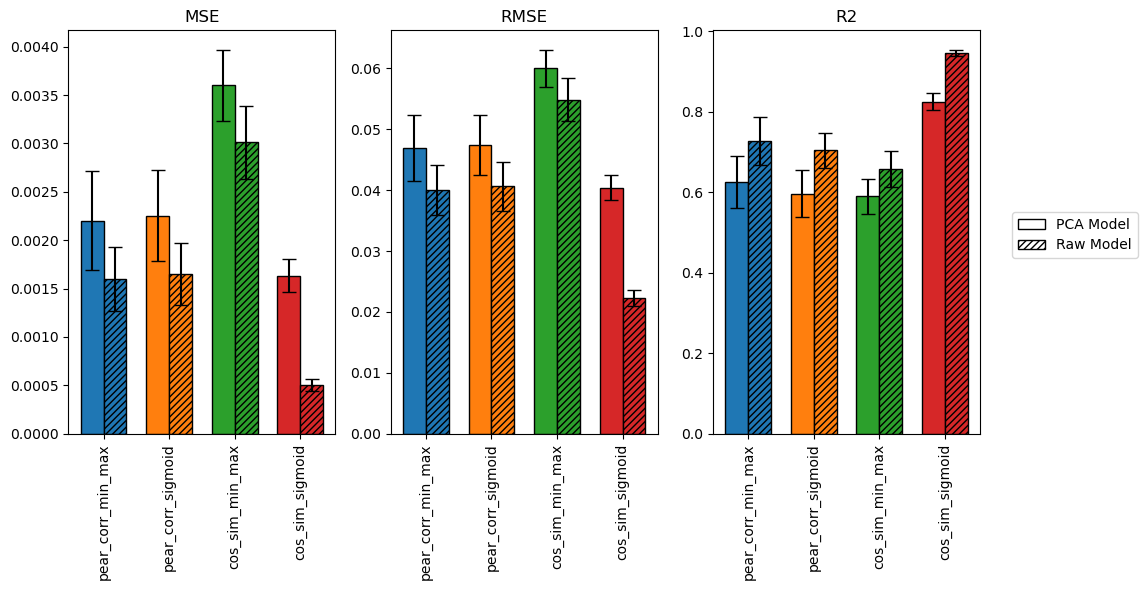

In [3]:
metrics = ["MSE", "RMSE", "R2"]
short_labels = [short_names[var] for var in target_variables]

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(target_variables))

for ax, metric in zip(axes, metrics):
    pca_values = [pca_results[var][metric] for var in target_variables]
    pca_errors = [pca_results[var][f"{metric}_CI"] for var in target_variables]

    raw_values = [raw_results[var][metric] for var in target_variables]
    raw_errors = [raw_results[var][f"{metric}_CI"] for var in target_variables]

    target_colors = [colors[short_names[var]] for var in target_variables]

    # PCA bars (no hatch)
    pca_bars = ax.bar(x - bar_width/2, pca_values, bar_width, yerr=pca_errors, 
                      capsize=5, color=target_colors, edgecolor='black', label='PCA Model')

    # Raw bars (with hatch)
    raw_bars = ax.bar(x + bar_width/2, raw_values, bar_width, yerr=raw_errors, 
                      capsize=5, color=target_colors, edgecolor='black', hatch='/////', label='Raw Model')

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(short_labels, rotation=90)

# Create a custom legend that differs only by hatching, not color
pca_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='', label='PCA Model')
raw_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/////', label='Raw Model')

fig.legend(handles=[pca_patch, raw_patch], labels=['PCA Model', 'Raw Model'], 
           loc='center left', bbox_to_anchor=(1.01, 0.6))

plt.tight_layout()
plt.show()